## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Create a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ai4i2020.csv")

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
def add_text_to_bar_chart(text_list, bar):
    i =0
    for bar in chart:
      plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, text_list[i], horizontalalignment="center")
      i +=1

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

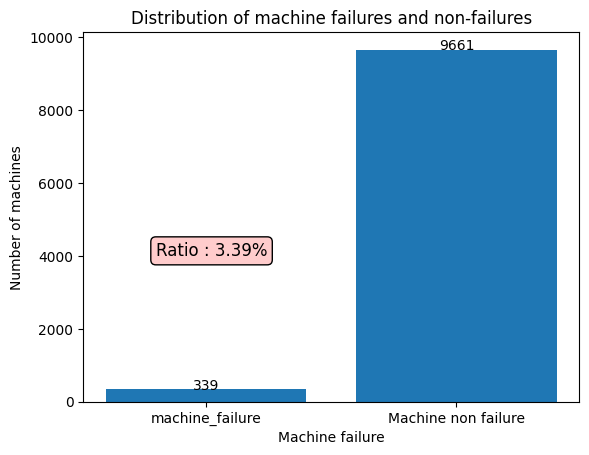

In [ ]:
machine_non_failure = data[data['Machine failure'] == 0]
machine_failure = data[data['Machine failure'] == 1]

chart = plt.bar(["machine_failure", "Machine non failure"], [len(machine_failure),len(machine_non_failure)], width=0.8)
plt.title("Distribution of machine failures and non-failures")
plt.xlabel("Machine failure")
plt.ylabel("Number of machines")
plt.text(-0.2, 4000, "Ratio : " + str(round(100*len(machine_failure)/(len(machine_non_failure)+len(machine_failure)), 3)) + "%", fontsize=12, bbox=dict(boxstyle="round",ec=(0, 0, 0),fc=(1., 0.8, 0.8)))

add_text_to_bar_chart([len(machine_failure), len(machine_non_failure)], chart)

**ANALYSIS QUESTION:** What do you observe?



Le jeu de donnée est composé de 10000 machines. Il y 339 machines pour lequel machine_failure = 1 et 9661 machines pour lequel machine_failure =0.
La ratio machine_failure = 1/machine = 3.39%. Il y a donc une sous-représentation forte des machines avec une erreur. Cette proportion risque de biaisé les résultats du MLP.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

La proportion faible de machines défectueuses risque d'impacter négativements les résultats de notre MLP.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

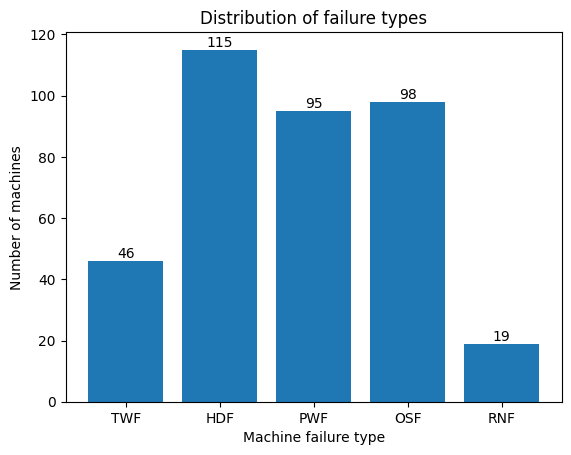

In [ ]:
machine_TWF = data[data['TWF'] == 1]
machine_HDF = data[data['HDF'] == 1]
machine_PWF = data[data['PWF'] == 1]
machine_OSF = data[data['OSF'] == 1]
machine_RNF = data[data['RNF'] == 1]

chart = plt.bar(["TWF", "HDF", "PWF", "OSF", "RNF"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF)], width=0.8)
plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")

add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF)], chart)

**ANALYSIS QUESTION:** What do you observe?

Au sein de la base, la représentation des erreurs est correctement distribués, à l'exception de RNF : Random Failure. Néanmoins, il n'est pas intéressant de prévoir une erreur aléatoire. Nous pouvons donc retirer les données relatives à ces erreurs pour améliorer la qualité de la base.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

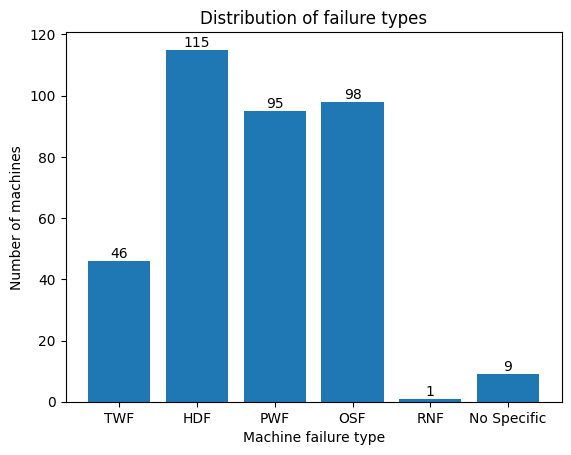

In [ ]:
machine_TWF = data[data['Machine failure'] == 1]
machine_TWF = machine_TWF[machine_TWF['TWF'] == 1]
machine_HDF = data[data['Machine failure'] == 1]
machine_HDF = machine_HDF[machine_HDF['HDF'] == 1]
machine_PWF = data[data['Machine failure'] == 1]
machine_PWF = machine_PWF[machine_PWF['PWF'] == 1]
machine_OSF = data[data['Machine failure'] == 1]
machine_OSF = machine_OSF[machine_OSF['OSF'] == 1]
machine_RNF = data[data['Machine failure'] == 1]
machine_RNF = machine_RNF[machine_RNF['RNF'] == 1]

machine_no_specific_failure = data[data['Machine failure'] == 1]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['TWF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['HDF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['PWF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['OSF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['RNF'] == 0]

no_specific_failure_line = []
machine_no_specific_failure_array = np.array(machine_no_specific_failure[1:])

for line in machine_no_specific_failure_array:
  no_specific_failure_line.append(line[0])


chart = plt.bar(["TWF", "HDF", "PWF", "OSF", "RNF", "No Specific"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF),len(machine_no_specific_failure)], width=0.8)
plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")

add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF), len(machine_no_specific_failure)], chart)

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

En comprarant ce diagramme et le diagramme précédent, on remarque qu'il existe des machines où machine_failure = 0, qui admettent une erreur. La base a donc été mal nettoyée. De plus, certaines erreurs ne sont pas connues.
Pour améliorer la qualité du MLP, nous pouvons retirer les données relatives aux RNF et aux No Specific.


**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
columns_names = data.columns
i = 0

for column in columns_names:
  print(f"> Id : {i} | Name : {column} | Type : {data[column].dtype}")
  i +=1

> Id : 0 | Name : UDI | Type : int64
> Id : 1 | Name : Product ID | Type : object
> Id : 2 | Name : Type | Type : object
> Id : 3 | Name : Air temperature [K] | Type : float64
> Id : 4 | Name : Process temperature [K] | Type : float64
> Id : 5 | Name : Rotational speed [rpm] | Type : int64
> Id : 6 | Name : Torque [Nm] | Type : float64
> Id : 7 | Name : Tool wear [min] | Type : int64
> Id : 8 | Name : Machine failure | Type : int64
> Id : 9 | Name : TWF | Type : int64
> Id : 10 | Name : HDF | Type : int64
> Id : 11 | Name : PWF | Type : int64
> Id : 12 | Name : OSF | Type : int64
> Id : 13 | Name : RNF | Type : int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to jsurtify your response.

6 entrées : Type, Air Temperature, Process Temperature, Rotational speed, Torque, Tool wear | 5 sorties -> Machine failure + Type

L'objectif est d'entraîner un algorithme de maintenance prédictive. Pour cela, nous disposons d'un set de 10000 données. Au sein de ces données, les informations utiles sont les informations sur la machine.

Ainsi, nous avons 5 entrées :
- Air Temperature
- Process Temperature
- Rotational speed
- Torque
- Tool wear

Nous souhaitons obtenir en sorties, si la machine va être défecteuse et l'erreur qu'elle va avoir (5 types possibles).

Nous avons donc 6 sorties :
- Machine Failure
- TWF
- HDF
- PWF
- OSF

In [ ]:
# Prepare Data

data_filtered = data.drop(index=no_specific_failure_line)

data_filtered= data_filtered[data_filtered['RNF'] == 0]

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
X = data_filtered.loc[:,'Air temperature [K]':'Tool wear [min]']

Y = data_filtered.loc[:, 'Machine failure':'OSF']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

print(f"Shape X_train : {X_train.shape}")
print(f"Shape X_test : {X_test.shape}")
print(f"Shape Y_train : {Y_train.shape}")
print(f"Shape Y_test : {Y_test.shape}")

Shape X_train : (6981, 5)
Shape X_test : (2992, 5)
Shape Y_train : (6981, 5)
Shape Y_test : (2992, 5)


In [ ]:
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.figure()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

**QUESTION** Code below the model architecture

In [ ]:
inputs = tf.keras.Input(shape=(5,)) # INPUT layer
x = tf.keras.layers.Flatten()(inputs)

nb_layers = 3
nb_neurons = [32,64,128] # Number of neurons per layer

for i in range(nb_layers): # Layers
  x = tf.keras.layers.Dense(nb_neurons[i], activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # OUTPUT layer with sofmax

mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model") # Create model

mlp_model.summary() # Display architecture

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten (Flatten)           (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 11,269
Trainable params: 11,269
Non-trainab

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/5
140/140 [==============================] - 4s 15ms/step - loss: 2.3748 - accuracy: 0.2210 - val_loss: 3.6674 - val_accuracy: 1.0000
Epoch 2/5
140/140 [==============================] - 2s 16ms/step - loss: 68.7437 - accuracy: 0.2292 - val_loss: 90.8436 - val_accuracy: 0.0000e+00
Epoch 3/5
140/140 [==============================] - 1s 8ms/step - loss: 446.4026 - accuracy: 0.2364 - val_loss: 890.5405 - val_accuracy: 0.0000e+00
Epoch 4/5
140/140 [==============================] - 1s 9ms/step - loss: 1730.6976 - accuracy: 0.2265 - val_loss: 835.3530 - val_accuracy: 1.0000
Epoch 5/5
60/60 [==============================] - 0s 4ms/step - loss: 7149.4316 - accuracy: 0.0000e+00
Performance on the TRAIN set, ACCURACY= 0.0
Performance on the TEST set, ACCURACY= 0.0


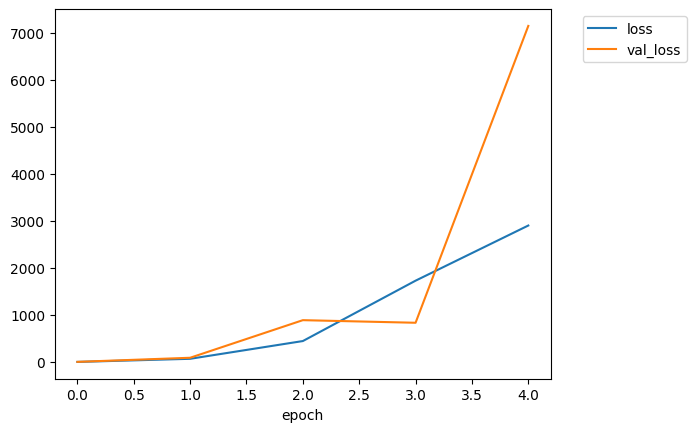

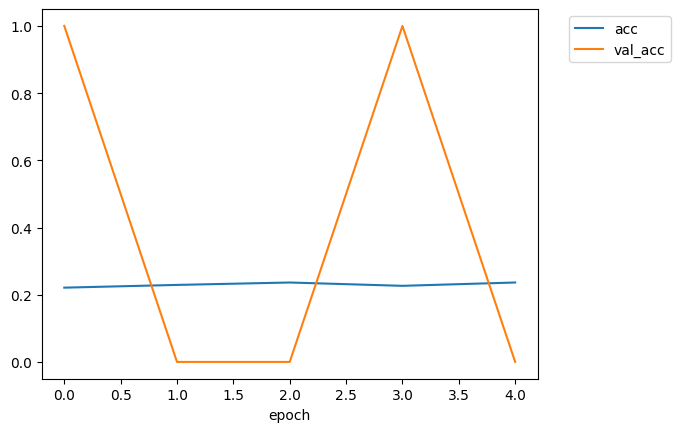

In [ ]:
# Training model
nb_epochs=5
batch_size=50
training_history = mlp_model.fit(X_train,Y_train,validation_data=(X_test, Y_test),epochs=nb_epochs,batch_size=batch_size)

# Accuracy
loss_train, acc_train = mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    2992.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00    2992.0
   macro avg       0.00      0.00      0.00    2992.0
weighted avg       0.00      0.00      0.00    2992.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

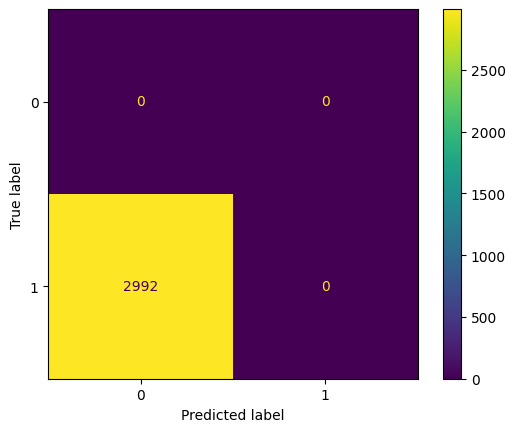

In [ ]:
predictions = mlp_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
Y_test = np.argmax(Y_test.values, axis=1)

# Classification report
print(classification_report(Y_test, predictions))

# Matrix
confusion_matrix_1 = confusion_matrix(predictions,Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_1)
disp.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

On remarque que la grande majorité des prédictions sont correctes, mais se place dans un unique label. À cause de la base de données et de la sureprésentation des machines fonctionnelles , le MLP "comprend" que si il met toutes ses prédictions sur machine fonctionnelle, cela augmentera fortement l'accurancy, vu que la majorité des label de test sont des machines fonctionnelles.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
sm = SMOTE(sampling_strategy='auto')

data_filtered = data.copy()
# On invers les 1 et 0 de la colonne 'Machine failure', pour éviter de retirer toutes les machines qui ont un problème
data_filtered['Machine failure'] = data_filtered['Machine failure'].apply(lambda x: 1 if x == 0 else 0)

# On retire les données qui n'admettent pas un unique un par lignes
condition = (
    ((data_filtered['Machine failure'] == 0) | (data_filtered['TWF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['HDF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['HDF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['HDF'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['HDF'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['PWF'] == 0) | (data_filtered['OSF'] == 0))
)
# Sélection des éléments qui satisfont la condition
selected_data = data_filtered[condition]
rejected_data = data_filtered[condition == 0]

X = selected_data.loc[:,'Air temperature [K]':'Tool wear [min]']

Y = selected_data.loc[:, 'Machine failure':'OSF']

Y_array = Y.to_numpy()

X_SMOTE, Y_SMOTE = sm.fit_resample(X, Y_array)
Y_panda_SMOTE = pd.DataFrame(Y_SMOTE)

X_rejected_data = rejected_data.loc[:,'Air temperature [K]':'Tool wear [min]']
Y_rejected_data = rejected_data.loc[:, 'Machine failure':'OSF']

Y_panda_SMOTE.columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']
X_panda_SMOTE_end = pd.concat([X_SMOTE, X_rejected_data], ignore_index=True)
Y_panda_SMOTE_end = pd.concat([Y_panda_SMOTE, Y_rejected_data], ignore_index=True)

X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(X_panda_SMOTE_end, Y_panda_SMOTE_end, test_size=0.30, random_state=42)


print(f"Shape X_train : {X_train_SMOTE.shape}")
print(f"Shape X_test : {X_test_SMOTE.shape}")
print(f"Shape Y_train : {Y_train_SMOTE.shape}")
print(f"Shape Y_test : {Y_test_SMOTE.shape}")

Shape X_train : (33861, 5)
Shape X_test : (14512, 5)
Shape Y_train : (33861, 5)
Shape Y_test : (14512, 5)


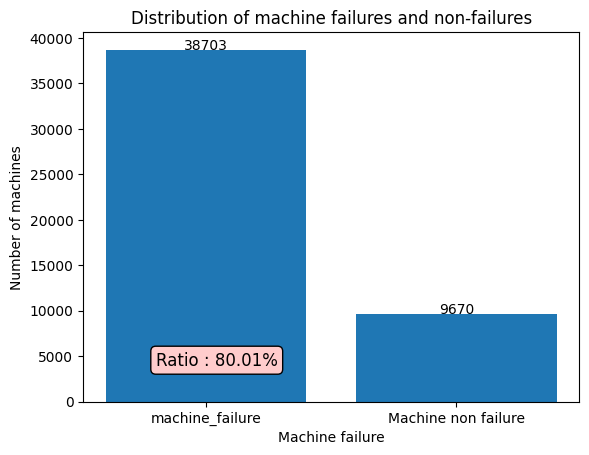

In [ ]:
machine_non_failure = Y_panda_SMOTE_end[Y_panda_SMOTE_end['Machine failure'] == 1]
machine_failure = Y_panda_SMOTE_end[Y_panda_SMOTE_end['Machine failure'] == 0]

chart = plt.bar(["machine_failure", "Machine non failure"], [len(machine_failure),len(machine_non_failure)], width=0.8)
plt.title("Distribution of machine failures and non-failures")
plt.xlabel("Machine failure")
plt.ylabel("Number of machines")
plt.text(-0.2, 4000, "Ratio : " + str(round(100*len(machine_failure)/(len(machine_non_failure)+len(machine_failure)), 3)) + "%", fontsize=12, bbox=dict(boxstyle="round",ec=(0, 0, 0),fc=(1., 0.8, 0.8)))

add_text_to_bar_chart([len(machine_failure), len(machine_non_failure)], chart)

Text(0, 0.5, 'Number of machines')

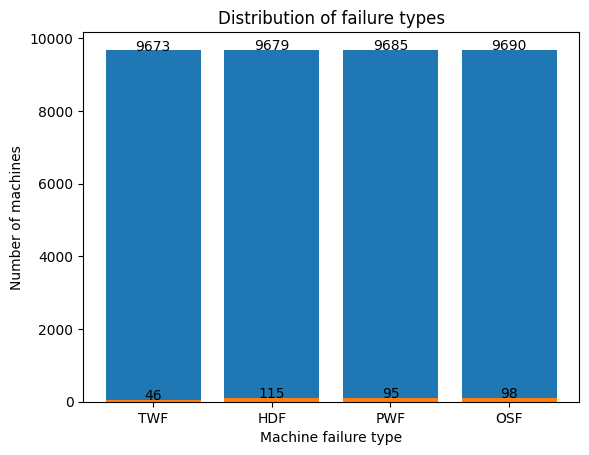

In [ ]:
machine_TWF_after = machine_failure[machine_failure['TWF'] == 1]
machine_HDF_after = machine_failure[machine_failure['HDF'] == 1]
machine_PWF_after = machine_failure[machine_failure['PWF'] == 1]
machine_OSF_after = machine_failure[machine_failure['OSF'] == 1]

chart = plt.bar(["TWF", "HDF", "PWF", "OSF"], [len(machine_TWF_after),len(machine_HDF_after), len(machine_PWF_after), len(machine_OSF_after)], width=0.8)
add_text_to_bar_chart([len(machine_TWF_after),len(machine_HDF_after), len(machine_PWF_after), len(machine_OSF_after)], chart)
chart = plt.bar(["TWF", "HDF", "PWF", "OSF"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF)], width=0.8)
add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF)], chart)

plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [ ]:
inputs = tf.keras.Input(shape=(5,)) # INPUT layer
x = tf.keras.layers.Flatten()(inputs)

nb_layers = 3
nb_neurons = [32,64,128] # Number of neurons per layer
dropout_rate = 0.5


for i in range(nb_layers): # Layers
  x = tf.keras.layers.Dense(nb_neurons[i], activation='relu')(x)
  if(i == 2):
    x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # OUTPUT layer with sofmax

mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model") # Create model

mlp_model.summary() # Display architecture

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten_3 (Flatten)         (None, 5)                 0         
                                                                 
 dense_11 (Dense)            (None, 32)                192       
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 5)                 64

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
339/339 [==============================] - 2s 5ms/step - loss: 0.5231 - accuracy: 0.7921 - val_loss: 0.2555 - val_accuracy: 0.9131
Epoch 2/20
339/339 [==============================] - 2s 5ms/step - loss: 0.4584 - accuracy: 0.8227 - val_loss: 0.3910 - val_accuracy: 0.8804
Epoch 3/20
339/339 [==============================] - 2s 5ms/step - loss: 0.4727 - accuracy: 0.8179 - val_loss: 0.2477 - val_accuracy: 0.9310
Epoch 4/20
339/339 [==============================] - 1s 3ms/step - loss: 0.4202 - accuracy: 0.8419 - val_loss: 0.2276 - val_accuracy: 0.9265
Epoch 5/20
339/339 [==============================] - 1s 3ms/step - loss: 0.4057 - accuracy: 0.8507 - val_loss: 0.2553 - val_accuracy: 0.9097
Epoch 6/20
339/339 [==============================] - 1s 3ms/step - loss: 0.4086 - accuracy: 0.8505 - val_loss: 0.2174 - val_accuracy: 0.9246
Epoch 7/20
339/339 [==============================] - 1s 3ms/step - loss: 0.3647 - accuracy: 0.8699 - val_loss: 0.2170 - val_accuracy: 0.9345
Epoch 

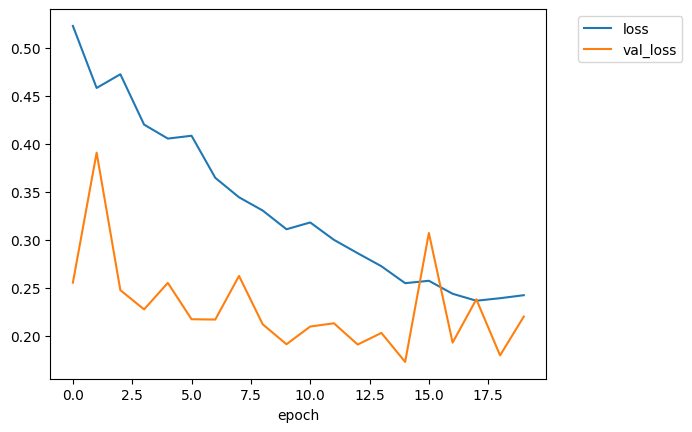

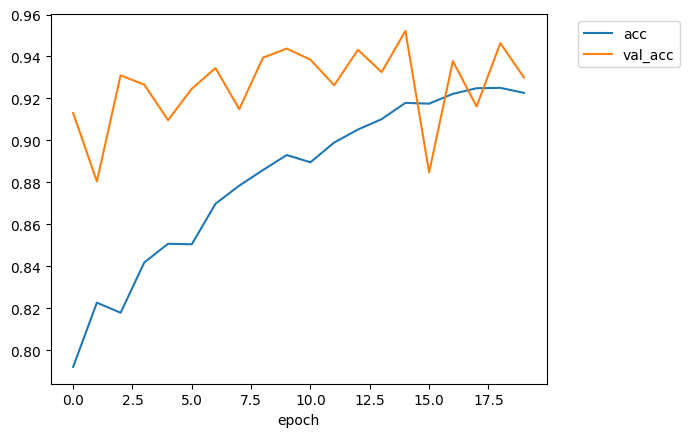

In [ ]:
# Training model
nb_epochs=20
batch_size=100
training_history = mlp_model.fit(X_train_SMOTE,Y_train_SMOTE,validation_data=(X_test_SMOTE, Y_test_SMOTE),epochs=nb_epochs,batch_size=batch_size)

# Accuracy
loss_train, acc_train = mlp_model.evaluate(X_train_SMOTE, Y_train_SMOTE, batch_size=batch_size)
loss_test, acc_test = mlp_model.evaluate(X_test_SMOTE, Y_test_SMOTE, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

454/454 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      2948
           1       0.85      1.00      0.92      2865
           2       0.89      0.92      0.91      2896
           3       0.99      0.99      0.99      2868
           4       0.96      0.99      0.98      2935

    accuracy                           0.93     14512
   macro avg       0.94      0.93      0.93     14512
weighted avg       0.94      0.93      0.93     14512



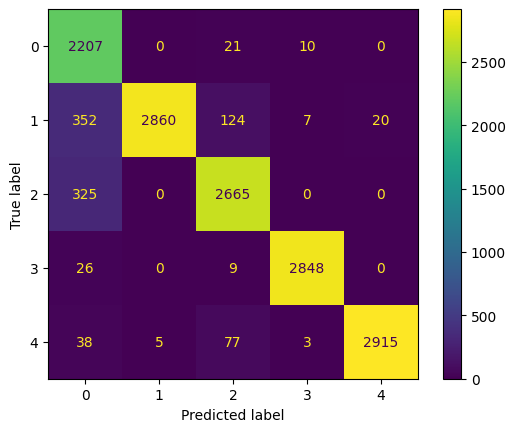

In [ ]:
predictions = mlp_model.predict(X_test_SMOTE)
predictions = np.argmax(predictions, axis=1)
Y_test_SMOTE_argmax = np.argmax(Y_test_SMOTE.values, axis=1)

# Classification report
print(classification_report(Y_test_SMOTE_argmax, predictions))

# Matrix
confusion_matrix_1 = confusion_matrix(predictions,Y_test_SMOTE_argmax)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_1)
disp.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

In [ ]:
np.save("Predict_machine_X.npy", X_test_SMOTE)
np.save("Predict_machine_Y.npy", Y_test_SMOTE)
mlp_model.save("Predict_machine.h5")